# Predictive validity of Morris indices for sensitivity analysis

This notebook replicates the analysis and the results of my master thesis.

## Contents



## Abbreviations

## Motivation

What is sensitivity analysis?

Why is it important?

What role does it play in Economics?

What are Shapley effects?
 - Theory

What are Morris indices?
 - Theory

Import packages needed in the replication of my analysis. 

In [1]:
import os
import profile
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import chaospy as cp

from mpl_toolkits.mplot3d import Axes3D
from functools import partial
from joblib import Parallel, delayed # Drop if fct. for simulation of uncertainty propagation is taken to aux.
from ruspy.model_code.demand_function import get_demand # Drop if fct. for simulation of uncertainty propagation is taken to aux.

from python.morris import elementary_effects # Import from econsa if PR is through.
from python.shapley import get_shapley # Import from econsa if PR is through.
from python.auxiliary import rust_model_shapley
from python.auxiliary import rust_model_morris
from python.auxiliary import x_all_raw
from python.auxiliary import x_cond_raw
from python.auxiliary import simulate_cov_and_mean_rc_theta_11
from python.auxiliary import compute_confidence_intervals # Drop if replicates of Shapley effects is taken to aux.
from python.auxiliary import setup_rust_model_001 # Specs of Rust model.
from python.auxiliary import shapley_replicate
from python.auxiliary import descriptives_and_data_shapley_effects

In [2]:
run_simulation_cov_mean = False
run_simulation_shapley_effects = False
run_simulation_uncertainty_propagation = False
n_cores = os.cpu_count()

## The Rust model
* Specs: why and what they mean.

In [3]:
model_setup = setup_rust_model_001()
params = model_setup['params']
ev = model_setup['ev']
costs = model_setup['costs']
trans_probs = model_setup['trans_probs']
trans_mat = model_setup['trans_mat']
init_dict_simulation = model_setup['init_dict_simulation']
init_dict_estimation = model_setup['init_dict_estimation']
demand_dict = model_setup['demand_dict']

* Simulate covariance matrix of inputs $RC$ and $\theta_{11}$.

In [7]:
%%time
# Simulation of 5,000 samples takes 3h 27min. (When using older version of the simulaton function.)
# Simulation of 10,000 samples takes 8h 33min 21s. (New version of function.)
num_sim = 10 ** 4
if run_simulation_cov_mean is True:
    cov, mean = simulate_cov_and_mean_rc_theta_11(num_sim, ev, costs, trans_mat, init_dict_simulation, init_dict_estimation)
    np.save(os.path.join('data', f'cov_rc_theta_11_{num_sim}'), cov)
    np.save(os.path.join('data', f'mean_rc_theta_11_{num_sim}'), mean)
elif run_simulation_cov_mean is False:
    cov = np.load(os.path.join('data', f'cov_rc_theta_11_{num_sim}.npy'))
    mean = np.load(os.path.join('data', f'mean_rc_theta_11_{num_sim}.npy'))
else:
    raise ValueError

Wall time: 35 ms


In [5]:
pd.DataFrame(data=cov, index= ['$RC$', '$\theta_{11}$'], columns=['$RC$', '$\theta_{11}$'])

,$RC$,$\theta_{11}$
$RC$,1.604736,0.605903
$\theta_{11}$,0.605903,0.273094


## Uncertainty propagation
How does the uncertainty in the inputs propagate to the output, implied annual demand?
Inspection of the distribution of the implied demand at certain $RC^{demand}$.

In [4]:
get_demand_partial = partial(get_demand, init_dict=init_dict_estimation, demand_dict=demand_dict)
def get_demand_mapping(x):
    return get_demand_partial(demand_params=x).iloc[0]['demand']

In [8]:
# Sample data.
num_sim_demand = 10 ** 5
input_variables = cp.MvNormal(params, cov).sample(num_sim_demand).T

In [9]:
demand_inputs = np.zeros((num_sim_demand, 5))
 # Trans prob.s stay the same.
demand_inputs[:, :3] = np.array([0.39189182, 0.59529371, 0.01281447])
demand_inputs[:, 3:] = input_variables[:, :]

In [10]:
%%time
# Use Joblib. 10 ** 4 runs take 30min 33s.
np.random.seed(123)
if run_simulation_uncertainty_propagation is True:
    implied_demand = Parallel(n_jobs=n_cores)(
            delayed(get_demand_mapping)(inp) for inp in demand_inputs
        )
    with open(os.path.join('data', f'implied_demand_{num_sim_demand}_runs.pickle'), 'wb') as handle:
        pickle.dump(implied_demand, handle)
else:
    with open(os.path.join('data', f'implied_demand_{num_sim_demand}_runs.pickle'), 'rb') as handle:
        implied_demand = pickle.load(handle)

Wall time: 97.9 ms


In [10]:
true_demand_params = np.concatenate((trans_probs, params))
true_implied_demand = get_demand(init_dict_estimation, demand_dict, true_demand_params).iloc[0]['demand']

In [11]:
implied_demand = np.asarray(implied_demand)

C:\Users\admin\anaconda3\envs\thesis-benedikt\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0, 0.0, ''),
 Text(0, 0.01, ''),
 Text(0, 0.02, ''),
 Text(0, 0.03, ''),
 Text(0, 0.04, ''),
 Text(0, 0.05, ''),
 Text(0, 0.06, ''),
 Text(0, 0.07, '')]

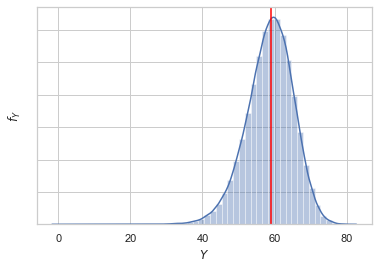

In [38]:
fig, ax = plt.subplots()

sns.distplot(implied_demand)

ax.set_xlabel(r"$Y$")
ax.set_ylabel(r"$f_Y$")

ax.axvline(x=true_implied_demand, ymin=0, ymax=1, color='red')

# ax.axvline(x=mean_implied_demand, ymin=0, ymax=1, color='grey')

ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
ax.axes.get_yaxis().set_ticklabels([])

In [13]:
# Save to png.
fig.savefig(fname=os.path.join('figures', f'uncertainty_propagation_{num_sim_demand}'), dpi=1000)

## Shapley effects

As a benchmark, I calculate Shapley effects for the Rust model (Rust 1987). To this end, I utilise the ruspy package (ref!) as well as the get_shapley method from the econsa package (ref!).

In [69]:
# Function inputs: mean and covariance matrix inputs.
n_inputs = 2
n_perms = None
np.random.seed(1234)

In [70]:
# Define model, and sampling functions.
model_shapley = partial(
    rust_model_shapley, trans_probs=trans_probs, init_dict_estimation=init_dict_estimation, demand_dict=demand_dict, 
)
x_all_partial = partial(x_all_raw, mean=params, cov=cov)
x_cond_partial = partial(x_cond_raw, mean=params, cov=cov)

### Finding the optimal $N_V$ (Number of MC runs used to estimate output variance).
For which values of $N_V$ does $V[Y]$ converge? Calculate $V[Y]$ for different numbers of Y. Use data simulated for uncertainty propagation.

In [42]:
rng = np.random.default_rng(123)
rng.shuffle(implied_demand)

In [43]:
n_output_variances = 100
output_variances = np.zeros(n_output_variances)
for i in np.arange(n_output_variances):
    k = (i + 1) * 10 ** 3
    output_variances[i] = np.var(implied_demand[0: k])

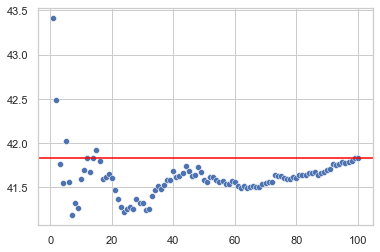

In [44]:
fig, ax = plt.subplots()
sns.set_theme(style='whitegrid')
ax = sns.scatterplot(x=np.arange(n_output_variances)+1, y=output_variances)

ax.axhline(y=np.var(implied_demand), xmin=0, xmax=n_output_variances, color='red')

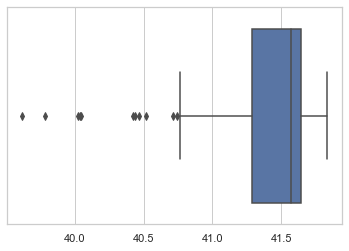

In [41]:
fig, ax = plt.subplots()
sns.set_theme(style='whitegrid')
ax = sns.boxplot(x=output_variances)

In [45]:
np.var(implied_demand)

41.829977408689864

In [50]:
rng = np.random.default_rng(123)
rng.shuffle(implied_demand)

In [53]:
# Construct differently sized samples to get when N_V converges.
bins = np.array([0, 0.625, 1, 1.5, 3.125, 6.250, 12.5, 25, 50, 100])
output_variances_different_sizes = np.zeros(len(bins))
for i in np.arange(len(bins) - 1):
    k_lower = int(bins[i] * 10 ** 3)
    k_upper = int(bins[i + 1] * 10 ** 3)
    # print(f'[{k_lower}, {k_upper}]')
    output_variances_different_sizes[i] = np.var(implied_demand[k_lower: k_upper])
output_variances_different_sizes = output_variances_different_sizes[:len(bins) - 1]

In [59]:
output_variances_different_sizes

array([38.64933438, 38.7131074 , 40.62723183, 40.83399446, 41.08886761,
       41.33252678, 41.91893398, 42.00393826, 42.21649992])

In [57]:
np.var(implied_demand)

41.82997740868987

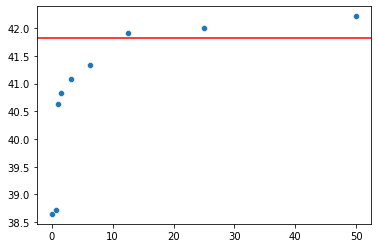

In [60]:
fig, ax = plt.subplots()
# sns.set_theme(style='whitegrid')
ax = sns.scatterplot(x=bins[:-1], y=output_variances_different_sizes)

ax.axhline(y=np.var(implied_demand), xmin=0, xmax=bins[-1], color='red')

### Compute Shapley effects for five values of $N_O$.
Keep $N_V$ and $N_I$ fixed at $12,500$ and $3$ respectively.

In [75]:
n_outer = 10 ** 4
n_inner = 3
n_evals = (np.math.factorial(n_inputs) * (n_inputs - 1) * n_outer * n_inner)
ratio_evals = n_evals/600 # 600 was baseline; 600 model evals took 92s.
92 * ratio_evals / 60 # Divide by 60 to get minutes.

153.33333333333334

In [72]:
%%time
np.random.seed(123)

# 100, 3 took 1min 32s.
# 10 ** 3, 3 took min s.

n_variance = 12.5 * 10 ** 3
n_outer = 10 ** 3
n_inner = 3
output_variance = np.var(implied_demand)

exact_shapley_{n_outer} = get_shapley(model_shapley, x_all_partial, x_cond_partial, n_perms, n_inputs, n_variance, n_outer, n_inner, n_cores, output_variance)
exact_shapley{n_outer}.rename(index={'X1': '$RC$', 'X2': '$\theta_{11}$'}, inplace=True)

Wall time: 15min 43s


In [74]:
exact_shapley_1000

,Shapley effects,std. errors,CI_min,CI_max
$RC$,0.422386,0.298672,-0.163011,1.007783
$\theta_{11}$,0.577614,0.298672,-0.007783,1.163011


In [65]:
exact_shapley_100

,Shapley effects,std. errors,CI_min,CI_max
$RC$,0.416791,0.294716,-0.160852,0.994433
$\theta_{11}$,0.583209,0.294716,0.005567,1.160852


### Replicates for uncertainty in Shapley effects.
Calculate a number of n_replicates Shapley effects. From these get standard errors and confidence intervals.

In [16]:
%%time
# n_replicates runs.

# 100 replicates ~ 1 h 30 m.

# 200 replicates ~ 2 h 37 m.

# PRB20 use 1,024, 64 and 3.
# Is used 100, 10, 3.
n_variance = 100
n_outer = 10
n_inner = 3

shapley_replicate_partial = partial(shapley_replicate, model_shapley, x_all_partial, x_cond_partial, n_perms, n_inputs, n_variance, n_outer, n_inner, n_cores)

n_replicates = 200

if run_simulation_shapley_effects is True:
    shapley_effects = list(map(shapley_replicate_partial, np.arange(n_replicates)))
    with open(os.path.join('data', f'shapley_effects_{n_replicates}_runs.pickle'), 'wb') as handle:
        pickle.dump(shapley_effects, handle)
else:
    with open(os.path.join('data', f'shapley_effects_{n_replicates}_runs.pickle'), 'rb') as handle:
        shapley_effects = pickle.load(handle)

Wall time: 226 ms


In [17]:
descriptives_shapley, data_boxplots = descriptives_and_data_shapley_effects(shapley_effects, n_replicates)

In [18]:
descriptives_shapley

,Mean,Std. errors,CI lower bound,CI upper bound
Shapley Effect,,,,
$RC$,0.415624,0.002604,0.410519,0.420729
$\theta_{11}$,0.584376,0.002604,0.579271,0.589481


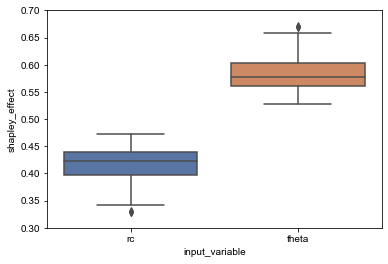

In [19]:
fig, ax = plt.subplots()
sns.set_theme(style='whitegrid')
ax.set(ylim=(0.3, 0.7))
ax = sns.boxplot(x=data_boxplots['input_variable'], y=data_boxplots['shapley_effect'])

In [20]:
fig.savefig(fname=os.path.join('figures', f'boxplot_shapley_effects_{n_replicates}'), dpi=1000)

## Morris method

Elementary, Watson.

### Setup for Morris indices
* `params` denotes the mean values of the model inputs
* `cov` denotes the covariance matrix
* 

In [21]:
# Use mean (simulated) or params (true values)?
params_df = pd.DataFrame(data=params, columns=['value'])
cov_df = pd.DataFrame(data=cov)

model_morris = partial(
    rust_model_morris, trans_probs=trans_probs, 
    init_dict_estimation=init_dict_estimation, demand_dict=demand_dict,
    )

In [22]:
%%time
n_draws = 100
# 1,000 samples take 20min 52s.
n_cores = os.cpu_count()
parallel = 'joblib'

morris_indices = elementary_effects(model_morris, params_df, cov_df, n_draws, 'sobol', n_cores, parallel)

Wall time: 1min 45s


## Comparing Shapley effects and Morris indices

Elementary.

# References
 - ruspy
 - econsa